In [139]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

import sklearn.metrics as skmetr
import xgboost as xgb
from xgboost import plot_importance

In [140]:
def print_errors(y_true, y_pred, msg):
    print('ERRORS in ' + msg)
    print('MAE: {0}'.format(skmetr.mean_absolute_error(y_true, y_pred)))
    print('RMSE: {0}'.format(np.sqrt(skmetr.mean_squared_error(y_true, y_pred))))
    print('MAPE: {0}'.format(np.mean(np.absolute(y_true - y_pred)/(y_true+1)*100)))
    print('RMSPE: {0}'.format(np.sqrt(np.mean(np.square(((y_true - y_pred) /(y_true+1))), axis=0))))

In [141]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [142]:
train_df = pd.read_csv('data/train_transformed.csv').reset_index(drop=True)
validation_df = pd.read_csv('data/validation_transformed.csv')

train_df = train_df.drop(columns='Unnamed: 0')
validation_df = validation_df.drop(columns='Unnamed: 0')

In [143]:
columns_to_drop = ['StateHoliday_0', 'StateHoliday_Christmas', 
                   'StateHoliday_Easter', 'StateHoliday_Public',
                   'SchoolHoliday_0.0', 'SchoolHoliday_1.0',
                   'Assortment_a', 'Assortment_b', 'Assortment_c'
                  ]

train_df = train_df.drop(columns = columns_to_drop)
validation_df = validation_df.drop(columns = columns_to_drop)

In [144]:
train_df.columns

Index(['Sales', 'CompetitionDistance', 'Store_cat', 'CompetitionSinceMonths',
       'Promo2SinceWeeks', 'Promo_0.0', 'Promo_1.0', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Month_1', 'Month_10',
       'Month_11', 'Month_12', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'DayOfWeek_0',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6'],
      dtype='object')

In [145]:
validation_df.columns

Index(['Sales', 'CompetitionDistance', 'Store_cat', 'CompetitionSinceMonths',
       'Promo2SinceWeeks', 'Promo_0.0', 'Promo_1.0', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Month_5', 'Month_6',
       'Month_7', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'Month_1', 'Month_10',
       'Month_11', 'Month_12', 'Month_2', 'Month_3', 'Month_4', 'Month_8',
       'Month_9'],
      dtype='object')

In [146]:
# feat_dict = {'only_time' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'Open'],
#              'only_comp' : ['CompetitionDistance', 'Promo2', 'Open', 'Promo'],
#              'only_store' : ['StoreType', 'Assortment', 'Open'],
#              'all_feat' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek','StateHoliday', 'SchoolHoliday', 
#                            'CompetitionDistance', 'Promo2', 'StoreType', 'Assortment', 'Open', 'Promo']}
# vars_list = feat_dict['all_feat']
vars_list = train_df.drop(columns = 'Sales').columns

dtrain = xgb.DMatrix(train_df[vars_list], label=train_df['Sales'])
deval = xgb.DMatrix(validation_df[vars_list], label=validation_df['Sales'])

In [147]:
params = {"objective": "reg:squarederror", 
          "booster" : "gbtree", 
          "seed": 10 }
num_of_trees = 1000

xgb_model_MK1 = xgb.train(params, dtrain, 
                      num_boost_round=num_of_trees,
                      early_stopping_rounds=20, 
                      evals=[(deval, "Eval")], 
                      verbose_eval=False)

In [148]:

pred_MK1 = xgb_model_MK1.predict(deval)
print_errors(validation_df['Sales'], pred_MK1, 'test dataset')

ERRORS in test dataset
MAE: 885.8952513514
RMSE: 1271.9566858992894
MAPE: 12.712634736022753
RMSPE: 0.17070517925321385


In [149]:
metric(pred_MK1, validation_df.Sales.to_numpy())

17.07440766255193

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

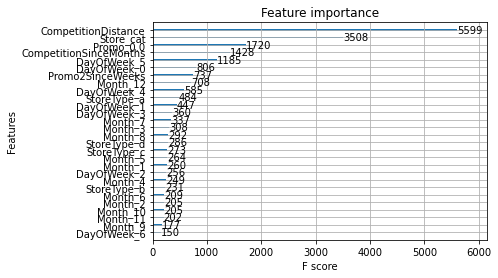

In [150]:
plot_importance(xgb_model_MK1)

In [151]:
params_upd1 = {"objective": "reg:squarederror", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "seed": 10                
          }
num_of_trees = 1000
early_stopping_rounds_N=20

xgb_model_MK2 = xgb.train(
                          params_upd1, 
                          dtrain, 
                          num_boost_round=num_of_trees,
                          early_stopping_rounds=early_stopping_rounds_N, 
                          evals=[(deval, "Eval")], 
                          verbose_eval=False
                         )

In [152]:
pred_MK2 = xgb_model_MK2.predict(deval)
print_errors(validation_df['Sales'], pred_MK2, 'test dataset')

ERRORS in test dataset
MAE: 882.6785850060212
RMSE: 1268.605678990492
MAPE: 12.663931814341508
RMSPE: 0.16990615910809198


In [153]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [154]:
metric(pred_MK2, validation_df.Sales.to_numpy())

16.99445156788967

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

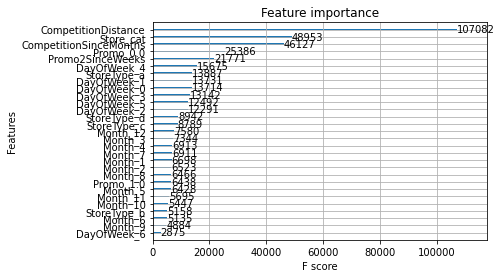

In [155]:
plot_importance(xgb_model_MK2)